In [88]:
from pytket.circuit import Circuit, Unitary1qBox, Unitary2qBox
import numpy as np
from pytket.circuit import OpType
from itertools import combinations

# u1 = np.asarray([[1, 0],
#                  [0, 1]])
# u1box = Unitary1qBox(u1)

input_angle = 0.73  # angle as number of half turns
unitary_circuit = Circuit(1).U1(input_angle, 0)  # Base unitary for controlled U ops


from pytket.circuit import Op


base_u1 = Op.create(OpType.U1, [0.5])


from pytket.circuit import QControlBox
from pytket.circuit import CircBox




from pytket.pauli import PauliStabiliser
from pytket.pauli import Pauli

phase_stabilise_z = PauliStabiliser([Pauli.Z], 1)

from pytket import Circuit
from pytket import OpType
from pytket.circuit.display import render_circuit_jupyter

from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

my_circuit = Circuit(3)
def run(qubit_count):
    controlled_u1 = QControlBox(CircBox(unitary_circuit), n=qubit_count-1)
    my_circuit = Circuit(qubit_count)
    needed_c_count = len(list(powerset([ _ for j in range(qubit_count-1)])))
    print('needed_c_count: ', needed_c_count)
    cr = my_circuit.add_c_register("c", needed_c_count)

    #prep
    for i in range(qubit_count):
        if i == 0:
            my_circuit.H(0)
        else:
            my_circuit.X(i)
    
    
    for i in range(qubit_count):
        # block 2 applying the unitary operation
        for j in range(2**(qubit_count-i-1)):
            my_circuit.add_gate(controlled_u1, range(qubit_count))
            
        #block 3 measure
        my_circuit.H(0)
        my_circuit.Measure(0, i) 
        if i < qubit_count-1: # still more to go    
            my_circuit.Reset(0)
            my_circuit.H(0)
            #phase correction now since there is more to go
            fractions = [ 0.5**(z+1) for z in range(i+1)]
            #for z in range(i+1): # this iterates through how many were there previously
                #use put .5 to the power of z+1 so that it goes .5, .25, .125, etc etc 
            #    fraction = 0.5**(z+1)
            #    fractions.append(fraction)
            #    my_circuit.Rz(-fraction, 0, condition_bits= [0], condition_value=1)
        
            #after adding the individual, if there was more than one do the combinations
            condition_bit = 0
            for set in sorted(list(powerset(fractions))):
                if len(set)==0:
                    continue
                combo = sum(set)
                
                my_circuit.Rz(-combo, 0, condition_bits= [condition_bit], condition_value=1)
                condition_bit = condition_bit + 1

    #block 4
    #my_circuit.add_gate(controlled_u1, [0, 1, 2])
    #my_circuit.add_gate(controlled_u1, [0, 1, 2])
    
    #block 5
    #my_circuit.H(0)
    #my_circuit.Measure(0, 1)
    #my_circuit.Reset(0)
    #my_circuit.H(0)
    
    #block 6
    #my_circuit.Rz(-0.25, 0, condition_bits=[0], condition_value=1)
    #my_circuit.Rz(-0.5, 0, condition_bits=[1], condition_value=1)
    #my_circuit.Rz(-0.75, 0, condition_bits=[2], condition_value=1)
    #my_circuit.add_gate(controlled_u1, [0, 1, 2])
    #my_circuit.H(0)
    #my_circuit.Measure(0, 2)
    
    # my_circuit.measure_all()
    
    my_circuit.name = "test"
    
    #render_circuit_jupyter(my_circuit)

    return my_circuit
    
    
    
my_circuit = run(3)

render_circuit_jupyter(my_circuit)

needed_c_count:  4


In [89]:
####---------####
    
from pytket.extensions.nexus import NexusBackend, QuantinuumConfig, Nexus
from datetime import datetime
from pytket.extensions.quantinuum import QuantinuumBackend, QuantinuumAPIOffline
api_offline = QuantinuumAPIOffline()

nexus = Nexus()
my_project = nexus.new_project(name=f"Nexus iQuHack tutorial project! - {datetime.now()}")

configuration = QuantinuumConfig(device_name="H1-1E", api_handler= api_offline) # to go back to noise do H1-1LE and user_group=iQuHACK_2024 

backend = NexusBackend(
    backend_config= configuration, 
    project= my_project
)

from pytket.passes import DecomposeBoxes

DecomposeBoxes().apply(my_circuit)


from pytket.extensions.nexus import NexusBackend

# Then we'll create a NexusBackend using our config and the project we created
backend = NexusBackend(configuration, project=my_project)

# Compile the circuit in Nexus
compiled_circ = backend.get_compiled_circuit(my_circuit)


# Run the compiled circuit for 10 shots
handle = backend.process_circuit(compiled_circ, n_shots=10)


# This will give you a ResultHandle
# As with other pytket-backends, a ResultHandle identifies a particular run of the circuit, which you can then use to keep track of the job status.
print('Result handle: ',handle)


# Get an update on the status
backend.circuit_status(handle)


# If the job is COMPLETED we can then retrieve the result with the handle
result = backend.get_result(handle)


result.get_distribution()


New project created: Nexus iQuHack tutorial project! - 2024-02-04 02:54:01.094865

Started using project with name: Nexus iQuHack tutorial project! - 2024-02-04 02:54:01.094865

Started using project with name: Nexus iQuHack tutorial project! - 2024-02-04 02:54:01.094865
Result handle:  ('5c61ac29-b269-42cc-8dbd-937bbf9d1612', 1898393)


{(1, 1, 0): 1.0}

In [90]:

n_shots = 500
result = backend.run_circuit(compiled_circ, n_shots)

print('counts: ', result.get_counts())


counts:  Counter({(1, 1, 0): 475, (0, 0, 0): 5, (0, 1, 0): 5, (1, 0, 0): 5, (1, 1, 1): 5, (0, 0, 1): 3, (0, 1, 1): 1, (1, 0, 1): 1})


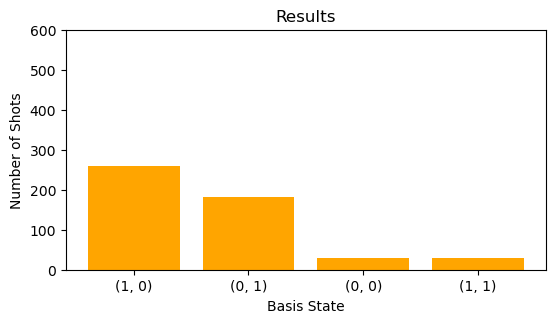

In [86]:

from pytket.backends.backendresult import BackendResult
import matplotlib.pyplot as plt

def plot_qpe_results(
    sim_result: BackendResult,
    n_strings: int = 10,
    dark_mode: bool = False,
    y_limit: int = 1000,
) -> None:
    """
    Plots results in a barchart given a BackendResult. the number of stings displayed
    can be specified with the n_strings argument.
    """
    counts_dict = sim_result.get_counts()
    sorted_shots = counts_dict.most_common()
    n_most_common_strings = sorted_shots[:n_strings]
    x_axis_values = [str(entry[0]) for entry in n_most_common_strings]  # basis states
    y_axis_values = [entry[1] for entry in n_most_common_strings]  # counts
    if dark_mode:
        plt.style.use("dark_background")
    fig = plt.figure()
    ax = fig.add_axes((0, 0, 0.75, 0.5))
    color_list = ["orange"] * (len(x_axis_values))
    ax.bar(
        x=x_axis_values,
        height=y_axis_values,
        color=color_list,
    )
    ax.set_title(label="Results")
    plt.ylim([0, y_limit])
    plt.xlabel("Basis State")
    plt.ylabel("Number of Shots")
    plt.show()


plot_qpe_results(result, y_limit=int(1.2 * n_shots))



In [87]:
from pytket.backends.backendresult import BackendResult


def single_phase_from_backendresult(result: BackendResult) -> float:
    # Extract most common measurement outcome
    basis_state = result.get_counts().most_common()[0][0]
    bitstring = "".join([str(bit) for bit in basis_state])
    integer_j = int(bitstring, 2)

    # Calculate theta estimate
    return integer_j / (2 ** len(bitstring))


theta = single_phase_from_backendresult(result)
print('theta: ' , theta)

print('inputangle/2: ',input_angle / 2)

error = round(abs(input_angle - (theta)), 3)
print('error: ', error)

theta:  0.5
inputangle/2:  0.365
error:  0.23
